### Imports

In [3]:
from tqdm import tqdm
import random
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_mtsim
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/")
from gym_mtsim_forked.gym_mtsim.data import FOREX_DATA_PATH_TRAIN, FOREX_DATA_PATH_TEST, FOREX_DATA_PATH, STOCKS_DATA_PATH, FOREX_DATA_PATH_PRODUCTION, FOREX_DATA_PATH_1HR
from gym_mtsim import OrderType, Timeframe, MtEnv, MtSimulator
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, STATUS_FAIL
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from datetime import datetime, timedelta
import time
import torch
import pickle
import fx_rl

# Parameters

In [4]:
with open(FOREX_DATA_PATH, 'rb') as f:
    symbols_1hr = pickle.load(f)
# convert symbols_1hr to a pd.dataframe
symbols_1hr[1]['EURUSD'].index = pd.to_datetime(symbols_1hr[1]['EURUSD'].index)
max_date_1hr = symbols_1hr[1]['EURUSD'].index.max()

In [5]:
slices_1hr = fx_rl.slices_finder(symbols_1hr[1]['EURUSD'], max_date_1hr, testing_needed=False)

### Create Env

In [6]:
class MyMtEnv(gym_mtsim.MtEnv):
    # _get_modified_volume = fx_rl.my_get_modified_volume
    _get_prices = fx_rl.my_get_prices

In [7]:
sim_train = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

In [8]:
env_train = gym_mtsim.MtEnv(
    original_simulator=sim_train,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=slices_1hr[0],
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [9]:
sim_validation = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_validation = gym_mtsim.MtEnv(
    original_simulator=sim_validation,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=slices_1hr[1],
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [10]:
sim_validation_2 = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_validation_2 = gym_mtsim.MtEnv(
    original_simulator=sim_validation_2,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=slices_1hr[1],
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

### Define Functions

In [11]:
def print_stats(reward_over_episodes, printing_name):
    """  Print Reward  """

    avg_rewards = np.mean(reward_over_episodes)
    min_rewards = np.min(reward_over_episodes)
    max_rewards = np.max(reward_over_episodes)

    print (f'Min. {printing_name}          : {min_rewards:>10.3f}')
    print (f'Avg. {printing_name}          : {avg_rewards:>10.3f}')
    print (f'Max. {printing_name}          : {max_rewards:>10.3f}')

    return min_rewards, avg_rewards, max_rewards

def my_profit_calculation(env_orders, stop_loss):
        # env_orders = env_testing.render()['orders']
        # stop_loss = 0.001
        mean_value = env_orders['Volume'].mean()

        # # Normalize the column to have a mean of 1
        env_orders.loc[:, 'Volume'] = round((env_orders['Volume'] / mean_value), 2)
        # add a column for when the difference between the Entry Price and the Exit Price is greater than stop_loss
        env_orders.loc[:, 'stoploss_hit'] = np.where((env_orders['Type'].str.strip() == 'Buy') &
                                                        ((env_orders['Entry Price'] - env_orders['Exit Price']) > stop_loss),
                                                        1, np.where((env_orders['Type'].str.strip() == 'Sell') &
                                                                        ((env_orders['Exit Price'] - env_orders['Entry Price']) > stop_loss),
                                                                        1, 0))
        env_orders.loc[:, 'Exit Price'] = np.where((env_orders['Type'].str.strip() == 'Buy') & (env_orders['stoploss_hit'] == 1),
                                                        env_orders['Entry Price'] - stop_loss,
                                                        np.where((env_orders['Type'].str.strip() == 'Sell') & (env_orders['stoploss_hit'] == 1),
                                                                env_orders['Entry Price'] + stop_loss, env_orders['Exit Price']))
        env_orders.loc[:, 'Profit'] = np.where((env_orders['Type'].str.strip() == 'Buy'),
                                                        ((env_orders['Exit Price'] - (env_orders['Fee']/2)) - 
                                                        (env_orders['Entry Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume'], 
                                                        np.where((env_orders['Type'].str.strip() == 'Sell'),
                                                                ((env_orders['Entry Price'] - (env_orders['Fee']/2)) - 
                                                                (env_orders['Exit Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume'], np.nan))
        total_reward = env_orders.loc[:, 'Profit'].sum()
        # Calculate Gross Profit
        gross_profit = env_orders.loc[env_orders['Profit'] > 0, 'Profit'].sum()

        # Calculate Gross Loss
        gross_loss = env_orders.loc[env_orders['Profit'] < 0, 'Profit'].abs().sum()

        # Calculate Profit Factor
        profit_factor = gross_profit / gross_loss if gross_loss != 0 else 0

        profit_factor = profit_factor - 1

        return profit_factor, total_reward

# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


In [20]:
# TRAINING + TEST
def train_val_model(model, model_policy, env_tr, env_val, seed, steps_str, lr, gamma_param, entropy, total_learning_timesteps=10_000):
    """
    Trains and validates a model using the Proximal Policy Optimization (PPO) algorithm.

    Args:
        model (object): The model to be trained.
        model_policy (object): The policy used by the model.
        env_tr (object): The training environment.
        env_val (object): The validation environment.
        seed (int): The random seed for reproducibility.
        steps_str (str): A string representing the number of steps.
        window_size_param (int): The window size parameter.
        lr (float): The learning rate.
        gamma_param (float): The gamma parameter.
        entropy (float): The entropy coefficient.
        total_learning_timesteps (int, optional): The total number of learning timesteps. Defaults to 10,000.

    Returns:
        tuple: A tuple containing the reward over validations, orders over validations, and the model dictionary.
    """
    # reproduce training and test
    print('-' * 80)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    #model_dict = {}
    # env_tr.window_size = window_size_param
    print(f'entropy: {entropy}, learning rate: {lr}, gamma: {gamma_param}')
    # eval_callback = EvalCallback(env_tr, log_path='./logs/', eval_freq=1000)
    obs_tr, info_tr = env_tr.reset(seed=seed)
    model = PPO(model_policy, env_tr, verbose=0, ent_coef=entropy, learning_rate=lr)#, gamma=gamma_param, 
    
    # custom callback for 'progress_bar'
    model.learn(total_timesteps=total_learning_timesteps)#, callback=ProgressBarCallback(100))

    reward_over_validations = []
    orders_over_validations = []
    profit_over_validations = []

    for episode in range(0, 10):
        obs_val, info_val = env_val.reset(seed=seed)

        total_reward = 0
        done_val = False

        while not done_val:
            action, _states = model.predict(obs_val)
            obs_val, reward_val, terminated_val, truncated_val, info_val = env_val.step(action)
            done_val = terminated_val or truncated_val

            total_reward += reward_val
            if done_val:
                break
        try:
            orders_made_in_episode = env_val.render()['orders']
            order_len = len(orders_made_in_episode)
            total_reward, total_profit = my_profit_calculation(orders_made_in_episode, 0.001)
            
        except Exception as e:
            print('There were not any orders produced by the model')
            print(f'Here is the error {e}')
            order_len = 0
            total_profit = 0

        # model_dict[f'model_{episode}'] = model
        # model.save(f'best_hyperparameters/models_4_26_24/model_{episode}.pkl')

        reward_over_validations.append(total_reward) 
        profit_over_validations.append(total_profit)   
        orders_over_validations.append(order_len)  


        # if episode % 1 == 0:
        avg_reward = np.mean(reward_over_validations)
        avg_orders = np.mean(orders_over_validations)
        avg_profit = np.mean(profit_over_validations)
        print(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}, # of orders: {avg_orders:.3f}, avg Profit: {avg_profit:.3f}')
    model.save(f'models_{max_date_1hr.date()}/model_{steps_str}_{max_date_1hr.date()}.pkl')
    return reward_over_validations, orders_over_validations, profit_over_validations#, model_dict

## Objective Function

In [13]:
seed = 2024  # random seed
total_num_episodes = 10

# print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# learning_timesteps_list_in_K = [25]#, 50, 100]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html

timesteps_models_dict = {}
def objective(params):
    learning_timesteps = 100 #params['learning_timesteps']
    ent_coef = params['ent_coef']
    gamma = params['gamma'] #0.99 #
    learning_rate = params['learning_rate']#0.0003#

    if learning_rate > 0.08:
        print(f'Learning rate too high: {learning_rate}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    if ent_coef > 0.1:
        print(f'Entropy too high: {ent_coef}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}

    total_learning_timesteps = learning_timesteps * 1000
    step_key = f'{learning_timesteps}K'
    policy_dict = PPO.policy_aliases
    policy = policy_dict.get('MultiInputPolicy')
    class_name = type(PPO).__qualname__
    plot_key = f'{class_name}_rewards_'+step_key
    try:
        rewards, orders, profits = train_val_model(PPO, policy, env_train, env_validation, seed, step_key,  
                                                    learning_rate, gamma, ent_coef, total_learning_timesteps)
    except Exception as e:
        print(f'''there was an error {e} with those parameters: timesteps: {learning_timesteps}, \n
              ent_coef: {ent_coef}, gamma: {gamma}, learning_rate: {learning_rate}''')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    # timesteps_models_dict[step_key] = models_dict
    min_rewards, avg_rewards, max_rewards, = print_stats(rewards, 'Reward')
    print_stats(orders, 'Orders')
    label = f'Avg. {avg_rewards:>7.2f} : {class_name} - {step_key}'
    plot_data[plot_key] = rewards
    plot_settings[plot_key] = {'label': label}
    params['avg_orders'] = np.mean(orders)
    params['profits'] = np.mean(profits)       

    return {'loss': -avg_rewards, 'status': STATUS_OK, 'eval_time': time.time(), 'parameters': params} 

seed                     : 2024


In [14]:
# best_hyperparameters_current_week = pd.read_excel('best_hyperparameter_search_results.xlsx')

In [15]:
trials_latest_week = pickle.load(open(f'gym_mtsim_forked/examples/hyperopt/trials_5_17_search_next_week.pkl', 'rb'))
trials_latest_week_all_results = trials_latest_week.results
print(len(trials_latest_week_all_results),
trials_latest_week_all_results[0])

250 {'loss': -28.989188416963536, 'status': 'ok', 'eval_time': 1715980468.2894373, 'parameters': {'ent_coef': 0.0385069270635906, 'gamma': 0.9568912588294178, 'learning_rate': 0.01866046145280669, 'avg_orders': 36.3, 'rewards': 0.05394586565518563}}


In [16]:
trials_latest_week.best_trial

{'state': 2,
 'tid': 224,
 'spec': None,
 'result': {'loss': -1177.8298907055178,
  'status': 'ok',
  'eval_time': 1716039083.017912,
  'parameters': {'ent_coef': 0.0011367890106411677,
   'gamma': 0.9416691383716818,
   'learning_rate': 0.026460089849855668,
   'avg_orders': 24.8,
   'rewards': 1.9290342670391543}},
 'misc': {'tid': 224,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'ent_coef': [224], 'gamma': [224], 'learning_rate': [224]},
  'vals': {'ent_coef': [0.0011367890106411677],
   'gamma': [0.9416691383716818],
   'learning_rate': [0.026460089849855668]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2024, 5, 18, 13, 28, 9, 558000),
 'refresh_time': datetime.datetime(2024, 5, 18, 13, 31, 23, 17000)}

In [17]:
best_hyperparameters_current_week = pd.DataFrame()
new_dict = {}
for idx, result in enumerate(trials_latest_week_all_results):
    new_dict['loss'] = result['loss']
    new_dict['status'] = result['status']
    new_dict['learning_rate'] = result['parameters']['learning_rate']
    new_dict['ent_coef'] = result['parameters']['ent_coef']
    new_dict['gamma'] = result['parameters']['gamma']
    try:
        new_dict['orders'] = result['parameters']['avg_orders']
        new_dict['rewards'] = result['parameters']['rewards']
    except Exception as e: 
        new_dict['orders'] = 0
        new_dict['rewards'] = 0
    new_row = pd.DataFrame(new_dict, index=[idx])
    best_hyperparameters_current_week = pd.concat([best_hyperparameters_current_week, new_row], axis=0)
best_hyperparameters_current_week


,loss,status,learning_rate,ent_coef,gamma,orders,rewards
0,-28.989188,ok,0.018660,0.038507,0.956891,36.3,0.053946
1,10.609816,ok,0.003202,0.009890,0.939635,0.1,-0.100000
2,-13.247216,ok,0.025022,0.038900,0.937440,39.1,0.016948
3,29.697417,ok,0.002975,0.007454,0.960527,104.0,-0.006706
4,19.699558,ok,0.002955,0.018230,0.938070,0.8,0.553679
...,...,...,...,...,...,...,...
245,-283.258543,ok,0.037056,0.000070,0.931006,20.9,0.427490
246,51.063109,ok,0.022112,0.014385,0.942434,37.0,-0.028249
247,133.799695,ok,0.015936,0.021098,0.934058,45.0,-0.069388
248,98.009133,ok,0.038058,0.001041,0.939902,38.2,-0.087719


In [18]:
best_hyperparameters_current_week_success = best_hyperparameters_current_week[best_hyperparameters_current_week['status'] == 'ok']
best_hyperparameters_current_week_success_negative = best_hyperparameters_current_week_success[best_hyperparameters_current_week_success['loss'] < 0]
best_hyperparameters_current_week_success_negative = best_hyperparameters_current_week_success_negative.sort_values(by='loss', ascending=True)
best_hyperparameters_current_week_success_negative

,loss,status,learning_rate,ent_coef,gamma,orders,rewards
224,-1177.829891,ok,0.026460,0.001137,0.941669,24.8,1.929034
114,-861.134723,ok,0.032388,0.000059,0.935070,2.0,0.033623
89,-678.911910,ok,0.031810,0.004452,0.943984,48.2,0.537641
180,-653.672668,ok,0.018963,0.000079,0.932250,108.2,0.281889
60,-545.591384,ok,0.027795,0.002588,0.935848,26.3,0.596425
...,...,...,...,...,...,...,...
197,-5.636681,ok,0.024878,0.027399,0.928146,38.9,0.007843
113,-5.636681,ok,0.024363,0.037461,0.949387,38.9,0.007843
229,-5.636681,ok,0.022883,0.048445,0.952559,38.9,0.007843
75,-5.636681,ok,0.032488,0.000956,0.946843,38.9,0.007843


In [19]:
len(best_hyperparameters_current_week_success_negative)

66

In [21]:
best_hyperparameters_current_week_success_negative.loc[116,'ent_coef']

0.0109201230283189

In [21]:
profits_dict = {}
rewards_dict = {}
for idx in tqdm(best_hyperparameters_current_week_success_negative.index):
    parameters = {
        # 'window_size': 10,
        # 'learning_timesteps': 25,
        'ent_coef': best_hyperparameters_current_week_success_negative.loc[idx,'ent_coef'],
        'gamma': best_hyperparameters_current_week_success_negative.loc[idx,'gamma'],
        'learning_rate': best_hyperparameters_current_week_success_negative.loc[idx,'learning_rate']
    }
    rewards_250, orders_250, profits = train_val_model(PPO, 'MultiInputPolicy', env_train, env_validation, seed, str(idx),  
                                                parameters['learning_rate'], parameters['gamma'], parameters['ent_coef'], 250_000)
    print_stats(profits, 'Profits')
    print_stats(rewards_250, 'Rewards')
    profits_dict[f'{idx}'] = profits
    rewards_dict[f'{idx}'] = rewards_250

# I want to know out of all the ones that I tested, are there any that don't go negative in profits, and use that model, then use any of those models in the 1000 run test below

    

  0%|          | 0/66 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
entropy: 0.0011367890106411677, learning rate: 0.026460089849855668, gamma: 0.9416691383716818
Episode: 0, Avg. Reward: 0.169, # of orders: 35.000, avg Profit: 171.991
Episode: 1, Avg. Reward: 0.192, # of orders: 31.500, avg Profit: 169.846
Episode: 2, Avg. Reward: 0.088, # of orders: 30.333, avg Profit: 57.582
Episode: 3, Avg. Reward: -0.012, # of orders: 32.250, avg Profit: -50.680
Episode: 4, Avg. Reward: -0.124, # of orders: 32.400, avg Profit: -204.594
Episode: 5, Avg. Reward: 0.028, # of orders: 32.667, avg Profit: -21.608
Episode: 6, Avg. Reward: 0.005, # of orders: 32.571, avg Profit: -46.536
Episode: 7, Avg. Reward: -0.003, # of orders: 32.375, avg Profit: -47.349


c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:283: UserWarning: Path 'models_2024-05-17' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")
  2%|▏         | 1/66 [08:23<9:05:48, 503.82s/it]

Episode: 8, Avg. Reward: 0.049, # of orders: 33.000, avg Profit: 22.964
Episode: 9, Avg. Reward: 0.116, # of orders: 32.700, avg Profit: 76.989
Min. Profits          :   -820.251
Avg. Profits          :     76.989
Max. Profits          :    893.319
Min. Rewards          :     -0.573
Avg. Rewards          :      0.116
Max. Rewards          :      0.787
--------------------------------------------------------------------------------
entropy: 5.8880462605512794e-05, learning rate: 0.03238767408206728, gamma: 0.9350704741922176
Episode: 0, Avg. Reward: -0.096, # of orders: 60.000, avg Profit: -146.735
Episode: 1, Avg. Reward: 0.113, # of orders: 57.500, avg Profit: 160.689
Episode: 2, Avg. Reward: 0.217, # of orders: 57.333, avg Profit: 320.622
Episode: 3, Avg. Reward: 0.191, # of orders: 57.250, avg Profit: 288.737
Episode: 4, Avg. Reward: 0.467, # of orders: 58.200, avg Profit: 615.119
Episode: 5, Avg. Reward: 0.554, # of orders: 57.833, avg Profit: 772.628
Episode: 6, Avg. Reward: 0.618

  3%|▎         | 2/66 [16:57<9:03:30, 509.55s/it]

Episode: 8, Avg. Reward: 0.569, # of orders: 58.333, avg Profit: 779.367
Episode: 9, Avg. Reward: 0.602, # of orders: 56.900, avg Profit: 802.399
Min. Profits          :   -146.735
Avg. Profits          :    802.399
Max. Profits          :   1920.646
Min. Rewards          :     -0.096
Avg. Rewards          :      0.602
Max. Rewards          :      1.571
--------------------------------------------------------------------------------
entropy: 0.004451859080905401, learning rate: 0.03181014719478862, gamma: 0.9439841821446201
Episode: 0, Avg. Reward: 0.631, # of orders: 43.000, avg Profit: 766.941
Episode: 1, Avg. Reward: 1.149, # of orders: 42.500, avg Profit: 1002.159
Episode: 2, Avg. Reward: 0.951, # of orders: 41.333, avg Profit: 860.543
Episode: 3, Avg. Reward: 1.068, # of orders: 39.750, avg Profit: 954.831
Episode: 4, Avg. Reward: 1.202, # of orders: 39.200, avg Profit: 1084.660
Episode: 5, Avg. Reward: 1.212, # of orders: 39.667, avg Profit: 1137.849
Episode: 6, Avg. Reward: 1.23

  5%|▍         | 3/66 [24:54<8:39:14, 494.52s/it]

Episode: 8, Avg. Reward: 1.004, # of orders: 38.222, avg Profit: 990.461
Episode: 9, Avg. Reward: 0.941, # of orders: 37.700, avg Profit: 929.883
Min. Profits          :    -30.991
Avg. Profits          :    929.883
Max. Profits          :   1603.979
Min. Rewards          :     -0.037
Avg. Rewards          :      0.941
Max. Rewards          :      1.735
--------------------------------------------------------------------------------
entropy: 7.940632982336932e-05, learning rate: 0.018962535475199754, gamma: 0.9322495324121387
Episode: 0, Avg. Reward: 0.086, # of orders: 66.000, avg Profit: 138.179
Episode: 1, Avg. Reward: -0.083, # of orders: 65.000, avg Profit: -125.459
Episode: 2, Avg. Reward: 0.129, # of orders: 68.000, avg Profit: 219.624
Episode: 3, Avg. Reward: 0.102, # of orders: 67.250, avg Profit: 174.091
Episode: 4, Avg. Reward: 0.322, # of orders: 68.600, avg Profit: 432.233
Episode: 5, Avg. Reward: 0.390, # of orders: 68.000, avg Profit: 566.436
Episode: 6, Avg. Reward: 0.4

  6%|▌         | 4/66 [32:54<8:25:15, 488.95s/it]

Episode: 8, Avg. Reward: 0.477, # of orders: 68.667, avg Profit: 687.219
Episode: 9, Avg. Reward: 0.525, # of orders: 67.300, avg Profit: 749.184
Min. Profits          :   -389.096
Avg. Profits          :    749.184
Max. Profits          :   1464.799
Min. Rewards          :     -0.251
Avg. Rewards          :      0.525
Max. Rewards          :      1.201
--------------------------------------------------------------------------------
entropy: 0.0025877906299022722, learning rate: 0.027794504700116573, gamma: 0.935848457907727
Episode: 0, Avg. Reward: -0.065, # of orders: 36.000, avg Profit: -69.356
Episode: 1, Avg. Reward: -0.309, # of orders: 29.500, avg Profit: -274.551
Episode: 2, Avg. Reward: -0.115, # of orders: 31.000, avg Profit: -83.921
Episode: 3, Avg. Reward: -0.297, # of orders: 28.750, avg Profit: -229.663
Episode: 4, Avg. Reward: -0.265, # of orders: 29.400, avg Profit: -214.531
Episode: 5, Avg. Reward: -0.160, # of orders: 30.333, avg Profit: -110.204
Episode: 6, Avg. Rewa

  8%|▊         | 5/66 [41:00<8:15:59, 487.87s/it]

Episode: 8, Avg. Reward: -0.077, # of orders: 31.000, avg Profit: -43.753
Episode: 9, Avg. Reward: -0.039, # of orders: 30.500, avg Profit: -20.994
Min. Profits          :   -666.890
Avg. Profits          :    -20.994
Max. Profits          :    411.429
Min. Rewards          :     -0.842
Avg. Rewards          :     -0.039
Max. Rewards          :      0.367
--------------------------------------------------------------------------------
entropy: 0.008434342808520382, learning rate: 0.0161563254905715, gamma: 0.9341194605140145
Episode: 0, Avg. Reward: 0.084, # of orders: 42.000, avg Profit: 93.070
Episode: 1, Avg. Reward: -0.004, # of orders: 40.500, avg Profit: 3.439
Episode: 2, Avg. Reward: -0.118, # of orders: 39.333, avg Profit: -167.297
Episode: 3, Avg. Reward: -0.257, # of orders: 39.500, avg Profit: -387.359
Episode: 4, Avg. Reward: -0.338, # of orders: 39.000, avg Profit: -497.931
Episode: 5, Avg. Reward: -0.309, # of orders: 39.000, avg Profit: -455.808
Episode: 6, Avg. Reward: 

  9%|▉         | 6/66 [49:19<8:11:40, 491.67s/it]

Episode: 8, Avg. Reward: -0.242, # of orders: 38.444, avg Profit: -352.260
Episode: 9, Avg. Reward: -0.095, # of orders: 37.900, avg Profit: -228.581
Min. Profits          :  -1047.546
Avg. Profits          :   -228.581
Max. Profits          :    884.533
Min. Rewards          :     -0.676
Avg. Rewards          :     -0.095
Max. Rewards          :      1.224
--------------------------------------------------------------------------------
entropy: 0.016693973121133913, learning rate: 0.019204206945019134, gamma: 0.9327863046208954
Episode: 0, Avg. Reward: 0.038, # of orders: 37.000, avg Profit: 37.132
Episode: 1, Avg. Reward: -0.082, # of orders: 34.500, avg Profit: -60.420
Episode: 2, Avg. Reward: 0.154, # of orders: 38.333, avg Profit: 182.388
Episode: 3, Avg. Reward: -0.021, # of orders: 37.000, avg Profit: -6.044
Episode: 4, Avg. Reward: -0.144, # of orders: 34.400, avg Profit: -118.850
Episode: 5, Avg. Reward: -0.054, # of orders: 35.000, avg Profit: -24.588
Episode: 6, Avg. Reward:

 11%|█         | 7/66 [57:23<8:01:07, 489.27s/it]

Episode: 9, Avg. Reward: 0.010, # of orders: 32.800, avg Profit: -1.422
Min. Profits          :   -743.196
Avg. Profits          :     -1.422
Max. Profits          :    668.002
Min. Rewards          :     -0.812
Avg. Rewards          :      0.010
Max. Rewards          :      1.020
--------------------------------------------------------------------------------
entropy: 0.001133604772280598, learning rate: 0.020832155429841053, gamma: 0.9277733594452697
Episode: 0, Avg. Reward: -0.489, # of orders: 37.000, avg Profit: -807.849
Episode: 1, Avg. Reward: -0.142, # of orders: 35.000, avg Profit: -275.369
Episode: 2, Avg. Reward: -0.062, # of orders: 39.000, avg Profit: -130.753
Episode: 3, Avg. Reward: -0.026, # of orders: 40.000, avg Profit: -67.732
Episode: 4, Avg. Reward: -0.006, # of orders: 40.000, avg Profit: -35.366
Episode: 5, Avg. Reward: 0.050, # of orders: 41.167, avg Profit: 62.775
Episode: 6, Avg. Reward: 0.094, # of orders: 43.143, avg Profit: 145.400
Episode: 7, Avg. Reward: 

 12%|█▏        | 8/66 [1:05:39<7:55:01, 491.41s/it]

Episode: 8, Avg. Reward: 0.195, # of orders: 44.222, avg Profit: 291.772
Episode: 9, Avg. Reward: 0.269, # of orders: 43.300, avg Profit: 372.069
Min. Profits          :   -807.849
Avg. Profits          :    372.069
Max. Profits          :   1094.749
Min. Rewards          :     -0.489
Avg. Rewards          :      0.269
Max. Rewards          :      0.940
--------------------------------------------------------------------------------
entropy: 0.004311174982717123, learning rate: 0.008500926440862864, gamma: 0.9353321418223461
Episode: 0, Avg. Reward: -0.460, # of orders: 47.000, avg Profit: -704.695
Episode: 1, Avg. Reward: -0.135, # of orders: 45.500, avg Profit: -234.633
Episode: 2, Avg. Reward: -0.030, # of orders: 46.333, avg Profit: -61.208
Episode: 3, Avg. Reward: -0.011, # of orders: 46.500, avg Profit: -29.754
Episode: 4, Avg. Reward: 0.140, # of orders: 46.800, avg Profit: 152.887
Episode: 5, Avg. Reward: 0.317, # of orders: 46.000, avg Profit: 409.618
Episode: 6, Avg. Reward: 

 14%|█▎        | 9/66 [1:13:35<7:42:04, 486.39s/it]

Episode: 8, Avg. Reward: 0.412, # of orders: 46.000, avg Profit: 475.657
Episode: 9, Avg. Reward: 0.515, # of orders: 44.800, avg Profit: 547.512
Min. Profits          :   -704.695
Avg. Profits          :    547.512
Max. Profits          :   1693.273
Min. Rewards          :     -0.460
Avg. Rewards          :      0.515
Max. Rewards          :      1.435
--------------------------------------------------------------------------------
entropy: 0.0066672791989398185, learning rate: 0.032995534442150413, gamma: 0.9365975898530117
Episode: 0, Avg. Reward: -0.195, # of orders: 36.000, avg Profit: -222.543
Episode: 1, Avg. Reward: -0.122, # of orders: 35.000, avg Profit: -131.643
Episode: 2, Avg. Reward: -0.103, # of orders: 34.333, avg Profit: -116.122
Episode: 3, Avg. Reward: 0.039, # of orders: 37.250, avg Profit: 60.160
Episode: 4, Avg. Reward: -0.083, # of orders: 36.200, avg Profit: -87.933
Episode: 5, Avg. Reward: 0.017, # of orders: 36.000, avg Profit: 17.984
Episode: 6, Avg. Reward: 

 15%|█▌        | 10/66 [1:21:28<7:30:20, 482.51s/it]

Episode: 9, Avg. Reward: 0.208, # of orders: 32.700, avg Profit: 63.928
Min. Profits          :   -840.330
Avg. Profits          :     63.928
Max. Profits          :   1238.486
Min. Rewards          :     -0.867
Avg. Rewards          :      0.208
Max. Rewards          :      2.593
--------------------------------------------------------------------------------
entropy: 0.0023034035157827814, learning rate: 0.021936620020431306, gamma: 0.9487584352890396
Episode: 0, Avg. Reward: 0.204, # of orders: 58.000, avg Profit: 304.307
Episode: 1, Avg. Reward: -0.001, # of orders: 56.500, avg Profit: 26.201
Episode: 2, Avg. Reward: 0.193, # of orders: 60.333, avg Profit: 299.957
Episode: 3, Avg. Reward: 0.164, # of orders: 61.000, avg Profit: 258.758
Episode: 4, Avg. Reward: 0.285, # of orders: 61.400, avg Profit: 401.182
Episode: 5, Avg. Reward: 0.292, # of orders: 60.500, avg Profit: 411.534
Episode: 6, Avg. Reward: 0.287, # of orders: 60.571, avg Profit: 404.165
Episode: 7, Avg. Reward: 0.300,

 17%|█▋        | 11/66 [1:29:35<7:23:23, 483.71s/it]

Episode: 8, Avg. Reward: 0.259, # of orders: 59.889, avg Profit: 359.600
Episode: 9, Avg. Reward: 0.271, # of orders: 59.000, avg Profit: 366.388
Min. Profits          :   -251.905
Avg. Profits          :    366.388
Max. Profits          :    970.880
Min. Rewards          :     -0.206
Avg. Rewards          :      0.271
Max. Rewards          :      0.770
--------------------------------------------------------------------------------
entropy: 0.003086585044073187, learning rate: 0.031798308906407724, gamma: 0.9395120514050849
Episode: 0, Avg. Reward: -0.160, # of orders: 83.000, avg Profit: -329.879
Episode: 1, Avg. Reward: 0.058, # of orders: 80.500, avg Profit: 64.490
Episode: 2, Avg. Reward: 0.307, # of orders: 79.000, avg Profit: 432.812
Episode: 3, Avg. Reward: 0.304, # of orders: 78.500, avg Profit: 476.355
Episode: 4, Avg. Reward: 0.375, # of orders: 77.800, avg Profit: 626.947
Episode: 5, Avg. Reward: 0.393, # of orders: 77.000, avg Profit: 668.511
Episode: 6, Avg. Reward: 0.386

 18%|█▊        | 12/66 [1:37:55<7:19:48, 488.67s/it]

Episode: 8, Avg. Reward: 0.365, # of orders: 78.000, avg Profit: 621.560
Episode: 9, Avg. Reward: 0.373, # of orders: 77.600, avg Profit: 637.911
Min. Profits          :   -590.914
Avg. Profits          :    637.911
Max. Profits          :   1331.832
Min. Rewards          :     -0.227
Avg. Rewards          :      0.373
Max. Rewards          :      0.807
--------------------------------------------------------------------------------
entropy: 0.012550148290663102, learning rate: 0.03193705043580959, gamma: 0.9374954562439638
Episode: 0, Avg. Reward: 0.013, # of orders: 42.000, avg Profit: 16.045
Episode: 1, Avg. Reward: -0.066, # of orders: 37.000, avg Profit: -51.365
Episode: 2, Avg. Reward: 0.060, # of orders: 41.000, avg Profit: 103.657
Episode: 3, Avg. Reward: 0.082, # of orders: 42.500, avg Profit: 130.689
Episode: 4, Avg. Reward: 0.278, # of orders: 45.000, avg Profit: 367.971
Episode: 5, Avg. Reward: 0.290, # of orders: 44.333, avg Profit: 369.711
Episode: 6, Avg. Reward: 0.403, 

 20%|█▉        | 13/66 [1:45:51<7:08:15, 484.83s/it]

Episode: 8, Avg. Reward: 0.401, # of orders: 44.556, avg Profit: 474.318
Episode: 9, Avg. Reward: 0.403, # of orders: 43.500, avg Profit: 462.451
Min. Profits          :   -118.776
Avg. Profits          :    462.451
Max. Profits          :   1317.102
Min. Rewards          :     -0.144
Avg. Rewards          :      0.403
Max. Rewards          :      1.084
--------------------------------------------------------------------------------
entropy: 6.968888865232366e-05, learning rate: 0.0370559429234395, gamma: 0.9310056616962098
Episode: 0, Avg. Reward: 0.175, # of orders: 12.000, avg Profit: 74.982
Episode: 1, Avg. Reward: 0.476, # of orders: 14.000, avg Profit: 276.280
Episode: 2, Avg. Reward: 1.162, # of orders: 21.667, avg Profit: 980.940
Episode: 3, Avg. Reward: 0.690, # of orders: 21.500, avg Profit: 605.470
Episode: 4, Avg. Reward: 0.661, # of orders: 25.000, avg Profit: 606.931
Episode: 5, Avg. Reward: 0.441, # of orders: 22.833, avg Profit: 445.351
Episode: 6, Avg. Reward: 0.376, #

 21%|██        | 14/66 [1:54:20<7:06:26, 492.05s/it]

Episode: 8, Avg. Reward: 0.513, # of orders: 24.889, avg Profit: 447.695
Episode: 9, Avg. Reward: 0.380, # of orders: 24.800, avg Profit: 331.539
Min. Profits          :   -713.869
Avg. Profits          :    331.539
Max. Profits          :   2390.261
Min. Rewards          :     -0.813
Avg. Rewards          :      0.380
Max. Rewards          :      2.533
--------------------------------------------------------------------------------
entropy: 0.002429423195169482, learning rate: 0.025087358872768216, gamma: 0.9350377771776605
There were not any orders produced by the model
Here is the error 'Volume'
Episode: 0, Avg. Reward: 0.000, # of orders: 0.000, avg Profit: 0.000
There were not any orders produced by the model
Here is the error 'Volume'
Episode: 1, Avg. Reward: 0.000, # of orders: 0.000, avg Profit: 0.000
There were not any orders produced by the model
Here is the error 'Volume'
Episode: 2, Avg. Reward: 0.000, # of orders: 0.000, avg Profit: 0.000
There were not any orders produced

 23%|██▎       | 15/66 [2:02:13<6:53:30, 486.47s/it]

There were not any orders produced by the model
Here is the error 'Volume'
Episode: 9, Avg. Reward: 0.000, # of orders: 0.000, avg Profit: 0.000
Min. Profits          :      0.000
Avg. Profits          :      0.000
Max. Profits          :      0.000
Min. Rewards          :      0.000
Avg. Rewards          :      0.000
Max. Rewards          :      0.000
--------------------------------------------------------------------------------
entropy: 0.01482427042797293, learning rate: 0.033535472353321466, gamma: 0.9312803945227035
Episode: 0, Avg. Reward: -0.079, # of orders: 42.000, avg Profit: -98.835
Episode: 1, Avg. Reward: -0.144, # of orders: 38.000, avg Profit: -132.704
Episode: 2, Avg. Reward: -0.085, # of orders: 38.667, avg Profit: -75.486
Episode: 3, Avg. Reward: 0.102, # of orders: 42.000, avg Profit: 152.568
Episode: 4, Avg. Reward: -0.006, # of orders: 41.200, avg Profit: 14.466
Episode: 5, Avg. Reward: 0.027, # of orders: 41.167, avg Profit: 51.175
Episode: 6, Avg. Reward: 0.006

 24%|██▍       | 16/66 [2:10:19<6:45:19, 486.40s/it]

Episode: 9, Avg. Reward: 0.168, # of orders: 37.600, avg Profit: 73.536
Min. Profits          :   -756.769
Avg. Profits          :     73.536
Max. Profits          :   1127.312
Min. Rewards          :     -0.833
Avg. Rewards          :      0.168
Max. Rewards          :      2.282
--------------------------------------------------------------------------------
entropy: 0.002963469421948083, learning rate: 0.0152931828587828, gamma: 0.938704264271983
Episode: 0, Avg. Reward: 0.183, # of orders: 38.000, avg Profit: 182.951
Episode: 1, Avg. Reward: -0.129, # of orders: 37.000, avg Profit: -108.859
Episode: 2, Avg. Reward: -0.067, # of orders: 39.000, avg Profit: -49.632
Episode: 3, Avg. Reward: -0.002, # of orders: 41.000, avg Profit: 29.933
Episode: 4, Avg. Reward: 0.086, # of orders: 42.000, avg Profit: 128.679
Episode: 5, Avg. Reward: 0.290, # of orders: 42.000, avg Profit: 305.107
Episode: 6, Avg. Reward: 0.310, # of orders: 42.286, avg Profit: 335.085
Episode: 7, Avg. Reward: 0.299, 

 26%|██▌       | 17/66 [2:18:36<6:39:38, 489.35s/it]

Episode: 9, Avg. Reward: 0.350, # of orders: 41.200, avg Profit: 339.907
Min. Profits          :   -400.669
Avg. Profits          :    339.907
Max. Profits          :   1187.248
Min. Rewards          :     -0.441
Avg. Rewards          :      0.350
Max. Rewards          :      1.313
--------------------------------------------------------------------------------
entropy: 0.013554876771442154, learning rate: 0.02512879301661028, gamma: 0.9296418480582613
Episode: 0, Avg. Reward: 0.092, # of orders: 45.000, avg Profit: 107.552
Episode: 1, Avg. Reward: -0.002, # of orders: 39.500, avg Profit: 19.278
Episode: 2, Avg. Reward: 0.009, # of orders: 40.333, avg Profit: 24.886
Episode: 3, Avg. Reward: -0.201, # of orders: 36.000, avg Profit: -172.794
Episode: 4, Avg. Reward: -0.300, # of orders: 33.000, avg Profit: -239.733
Episode: 5, Avg. Reward: -0.233, # of orders: 34.667, avg Profit: -178.842
Episode: 6, Avg. Reward: -0.197, # of orders: 35.714, avg Profit: -150.459
Episode: 7, Avg. Reward: 

 27%|██▋       | 18/66 [2:26:47<6:32:01, 490.04s/it]

Episode: 8, Avg. Reward: -0.140, # of orders: 36.667, avg Profit: -103.540
Episode: 9, Avg. Reward: -0.023, # of orders: 37.000, avg Profit: -16.222
Min. Profits          :   -765.833
Avg. Profits          :    -16.222
Max. Profits          :    769.641
Min. Rewards          :     -0.829
Avg. Rewards          :     -0.023
Max. Rewards          :      1.028
--------------------------------------------------------------------------------
entropy: 4.9676791137729564e-05, learning rate: 0.026120764391937695, gamma: 0.9431919413968654
Episode: 0, Avg. Reward: -0.240, # of orders: 31.000, avg Profit: -203.532
Episode: 1, Avg. Reward: 0.197, # of orders: 34.000, avg Profit: 145.903
Episode: 2, Avg. Reward: 0.103, # of orders: 35.000, avg Profit: 61.889
Episode: 3, Avg. Reward: 0.064, # of orders: 36.250, avg Profit: 33.072
Episode: 4, Avg. Reward: -0.109, # of orders: 36.000, avg Profit: -239.853
Episode: 5, Avg. Reward: 0.042, # of orders: 35.500, avg Profit: -93.866
Episode: 6, Avg. Reward:

 29%|██▉       | 19/66 [2:34:46<6:21:14, 486.70s/it]

Episode: 8, Avg. Reward: -0.074, # of orders: 35.111, avg Profit: -238.016
Episode: 9, Avg. Reward: -0.136, # of orders: 34.500, avg Profit: -290.188
Min. Profits          :  -1426.704
Avg. Profits          :   -290.188
Max. Profits          :    636.066
Min. Rewards          :     -0.803
Avg. Rewards          :     -0.136
Max. Rewards          :      0.797
--------------------------------------------------------------------------------
entropy: 0.009951203749690645, learning rate: 0.01278791161373467, gamma: 0.9289350404409071
Episode: 0, Avg. Reward: -0.025, # of orders: 47.000, avg Profit: -29.037
Episode: 1, Avg. Reward: -0.079, # of orders: 42.000, avg Profit: -76.506
Episode: 2, Avg. Reward: 0.087, # of orders: 44.667, avg Profit: 118.434
Episode: 3, Avg. Reward: -0.142, # of orders: 40.750, avg Profit: -133.193
Episode: 4, Avg. Reward: -0.189, # of orders: 40.800, avg Profit: -199.568
Episode: 5, Avg. Reward: -0.099, # of orders: 41.333, avg Profit: -104.081
Episode: 6, Avg. Rew

 30%|███       | 20/66 [2:43:01<6:14:54, 489.02s/it]

Episode: 8, Avg. Reward: -0.110, # of orders: 40.444, avg Profit: -117.654
Episode: 9, Avg. Reward: 0.163, # of orders: 39.700, avg Profit: 9.645
Min. Profits          :   -888.075
Avg. Profits          :      9.645
Max. Profits          :   1155.340
Min. Rewards          :     -0.827
Avg. Rewards          :      0.163
Max. Rewards          :      2.616
--------------------------------------------------------------------------------
entropy: 0.005073406029133658, learning rate: 0.03494411144844135, gamma: 0.939499916664905
Episode: 0, Avg. Reward: 0.110, # of orders: 31.000, avg Profit: 77.380
Episode: 1, Avg. Reward: -0.029, # of orders: 35.500, avg Profit: -35.371
Episode: 2, Avg. Reward: 0.134, # of orders: 37.667, avg Profit: 101.669
Episode: 3, Avg. Reward: -0.007, # of orders: 38.750, avg Profit: -42.136
Episode: 4, Avg. Reward: -0.139, # of orders: 35.000, avg Profit: -126.798
Episode: 5, Avg. Reward: -0.038, # of orders: 35.333, avg Profit: -42.641
Episode: 6, Avg. Reward: -0.0

 32%|███▏      | 21/66 [2:51:08<6:06:29, 488.65s/it]

Episode: 9, Avg. Reward: 0.291, # of orders: 35.300, avg Profit: 25.734
Min. Profits          :   -473.548
Avg. Profits          :     25.734
Max. Profits          :   1010.105
Min. Rewards          :     -0.665
Avg. Rewards          :      0.291
Max. Rewards          :      3.667
--------------------------------------------------------------------------------
entropy: 0.016541779574748377, learning rate: 0.03414393171127802, gamma: 0.9496352678147792
Episode: 0, Avg. Reward: -0.068, # of orders: 39.000, avg Profit: -78.540
Episode: 1, Avg. Reward: -0.167, # of orders: 35.000, avg Profit: -135.112
Episode: 2, Avg. Reward: -0.076, # of orders: 37.333, avg Profit: -49.045
Episode: 3, Avg. Reward: -0.085, # of orders: 38.750, avg Profit: -70.849
Episode: 4, Avg. Reward: -0.180, # of orders: 36.000, avg Profit: -154.204
Episode: 5, Avg. Reward: -0.105, # of orders: 36.333, avg Profit: -79.945
Episode: 6, Avg. Reward: -0.096, # of orders: 37.000, avg Profit: -75.002
Episode: 7, Avg. Reward:

 33%|███▎      | 22/66 [2:59:07<5:56:04, 485.56s/it]

Episode: 8, Avg. Reward: -0.172, # of orders: 34.444, avg Profit: -132.816
Episode: 9, Avg. Reward: 0.133, # of orders: 34.200, avg Profit: 0.033
Min. Profits          :   -652.596
Avg. Profits          :      0.033
Max. Profits          :   1195.677
Min. Rewards          :     -0.857
Avg. Rewards          :      0.133
Max. Rewards          :      2.872
--------------------------------------------------------------------------------
entropy: 0.006423231631041616, learning rate: 0.02672706006521675, gamma: 0.9473333150318194
Episode: 0, Avg. Reward: -0.498, # of orders: 5.000, avg Profit: -74.682
Episode: 1, Avg. Reward: 0.390, # of orders: 5.500, avg Profit: 30.802
Episode: 2, Avg. Reward: 0.034, # of orders: 7.000, avg Profit: -98.731
Episode: 3, Avg. Reward: 0.057, # of orders: 7.500, avg Profit: -66.013
Episode: 4, Avg. Reward: 0.219, # of orders: 7.600, avg Profit: -12.634
Episode: 5, Avg. Reward: 0.508, # of orders: 7.833, avg Profit: 29.781
Episode: 6, Avg. Reward: 0.430, # of or

 35%|███▍      | 23/66 [3:06:43<5:41:44, 476.86s/it]

Episode: 8, Avg. Reward: 0.397, # of orders: 8.333, avg Profit: 37.591
Episode: 9, Avg. Reward: 0.264, # of orders: 8.000, avg Profit: 8.398
Min. Profits          :   -357.798
Avg. Profits          :      8.398
Max. Profits          :    241.853
Min. Rewards          :     -0.937
Avg. Rewards          :      0.264
Max. Rewards          :      1.955
--------------------------------------------------------------------------------
entropy: 0.008026999219438696, learning rate: 0.027398896025258593, gamma: 0.958821479667048
Episode: 0, Avg. Reward: 0.328, # of orders: 43.000, avg Profit: 335.570
Episode: 1, Avg. Reward: 0.238, # of orders: 44.000, avg Profit: 236.124
Episode: 2, Avg. Reward: 0.168, # of orders: 47.333, avg Profit: 171.994
Episode: 3, Avg. Reward: 0.168, # of orders: 48.750, avg Profit: 195.548
Episode: 4, Avg. Reward: 0.231, # of orders: 48.800, avg Profit: 267.097
Episode: 5, Avg. Reward: 0.341, # of orders: 49.000, avg Profit: 395.318
Episode: 6, Avg. Reward: 0.347, # of 

 36%|███▋      | 24/66 [3:14:35<5:32:37, 475.17s/it]

Episode: 8, Avg. Reward: 0.279, # of orders: 48.556, avg Profit: 321.241
Episode: 9, Avg. Reward: 0.299, # of orders: 47.700, avg Profit: 336.763
Min. Profits          :   -360.144
Avg. Profits          :    336.763
Max. Profits          :   1036.420
Min. Rewards          :     -0.238
Avg. Rewards          :      0.299
Max. Rewards          :      0.889
--------------------------------------------------------------------------------
entropy: 0.002479668923805599, learning rate: 0.02989362673985379, gamma: 0.9445448971512161
Episode: 0, Avg. Reward: -0.547, # of orders: 20.000, avg Profit: -599.934
Episode: 1, Avg. Reward: 0.250, # of orders: 27.500, avg Profit: 104.285
Episode: 2, Avg. Reward: 0.165, # of orders: 30.000, avg Profit: 67.434
Episode: 3, Avg. Reward: -0.056, # of orders: 28.000, avg Profit: -121.550
Episode: 4, Avg. Reward: -0.057, # of orders: 29.200, avg Profit: -111.615
Episode: 5, Avg. Reward: 0.046, # of orders: 31.000, avg Profit: 23.352
Episode: 6, Avg. Reward: 0.0

 38%|███▊      | 25/66 [3:22:53<5:29:32, 482.26s/it]

Episode: 8, Avg. Reward: 0.112, # of orders: 33.111, avg Profit: 109.373
Episode: 9, Avg. Reward: 0.057, # of orders: 32.300, avg Profit: 52.342
Min. Profits          :   -688.503
Avg. Profits          :     52.342
Max. Profits          :    813.638
Min. Rewards          :     -0.718
Avg. Rewards          :      0.057
Max. Rewards          :      1.047
--------------------------------------------------------------------------------
entropy: 0.0041179971987429995, learning rate: 0.0347666178887173, gamma: 0.933999267082964
Episode: 0, Avg. Reward: 0.198, # of orders: 51.000, avg Profit: 277.881
Episode: 1, Avg. Reward: -0.093, # of orders: 44.500, avg Profit: -79.908
Episode: 2, Avg. Reward: 0.118, # of orders: 51.667, avg Profit: 219.835
Episode: 3, Avg. Reward: 0.130, # of orders: 50.750, avg Profit: 218.556
Episode: 4, Avg. Reward: 0.325, # of orders: 52.600, avg Profit: 475.983
Episode: 5, Avg. Reward: 0.331, # of orders: 52.333, avg Profit: 473.785
Episode: 6, Avg. Reward: 0.405, #

 39%|███▉      | 26/66 [3:31:26<5:27:35, 491.38s/it]

Episode: 8, Avg. Reward: 0.481, # of orders: 53.444, avg Profit: 664.506
Episode: 9, Avg. Reward: 0.469, # of orders: 52.600, avg Profit: 642.281
Min. Profits          :   -437.698
Avg. Profits          :    642.281
Max. Profits          :   1505.693
Min. Rewards          :     -0.384
Avg. Rewards          :      0.469
Max. Rewards          :      1.119
--------------------------------------------------------------------------------
entropy: 7.23557259786913e-05, learning rate: 0.02565654131900468, gamma: 0.9273429876800814
Episode: 0, Avg. Reward: -0.567, # of orders: 25.000, avg Profit: -414.568
Episode: 1, Avg. Reward: -0.592, # of orders: 27.000, avg Profit: -465.632
Episode: 2, Avg. Reward: -0.193, # of orders: 27.667, avg Profit: -180.964
Episode: 3, Avg. Reward: -0.127, # of orders: 29.250, avg Profit: -118.597
Episode: 4, Avg. Reward: 0.086, # of orders: 30.200, avg Profit: 48.332
Episode: 5, Avg. Reward: 0.214, # of orders: 29.500, avg Profit: 114.927
Episode: 6, Avg. Reward: 

 41%|████      | 27/66 [3:39:20<5:15:59, 486.15s/it]

Episode: 9, Avg. Reward: 0.251, # of orders: 29.700, avg Profit: 143.171
Min. Profits          :   -516.697
Avg. Profits          :    143.171
Max. Profits          :    716.047
Min. Rewards          :     -0.616
Avg. Rewards          :      0.251
Max. Rewards          :      0.938
--------------------------------------------------------------------------------
entropy: 6.030596413426773e-05, learning rate: 0.018367170967712884, gamma: 0.935880766185652
Episode: 0, Avg. Reward: -0.612, # of orders: 22.000, avg Profit: -375.485
Episode: 1, Avg. Reward: -0.683, # of orders: 24.500, avg Profit: -483.660
Episode: 2, Avg. Reward: -0.402, # of orders: 26.000, avg Profit: -295.413
Episode: 3, Avg. Reward: -0.288, # of orders: 28.500, avg Profit: -210.843
Episode: 4, Avg. Reward: 0.012, # of orders: 29.200, avg Profit: -40.035
Episode: 5, Avg. Reward: 0.102, # of orders: 28.000, avg Profit: 5.816
Episode: 6, Avg. Reward: 0.038, # of orders: 27.714, avg Profit: -25.412


 42%|████▏     | 28/66 [3:47:14<5:05:38, 482.59s/it]

Episode: 7, Avg. Reward: 0.255, # of orders: 27.625, avg Profit: 63.065
Episode: 8, Avg. Reward: 0.172, # of orders: 28.000, avg Profit: 11.665
Episode: 9, Avg. Reward: 0.131, # of orders: 27.400, avg Profit: -6.519
Min. Profits          :   -591.834
Avg. Profits          :     -6.519
Max. Profits          :    682.406
Min. Rewards          :     -0.755
Avg. Rewards          :      0.131
Max. Rewards          :      1.779
--------------------------------------------------------------------------------
entropy: 0.03218961211190564, learning rate: 0.0018873816179609676, gamma: 0.9439950816115786
Episode: 0, Avg. Reward: -0.004, # of orders: 54.000, avg Profit: -5.083
Episode: 1, Avg. Reward: 0.049, # of orders: 50.500, avg Profit: 54.565
Episode: 2, Avg. Reward: 0.086, # of orders: 53.000, avg Profit: 111.619
Episode: 3, Avg. Reward: 0.049, # of orders: 54.000, avg Profit: 58.526
Episode: 4, Avg. Reward: 0.084, # of orders: 53.800, avg Profit: 113.807
Episode: 5, Avg. Reward: 0.187, # of

 44%|████▍     | 29/66 [3:55:25<4:59:08, 485.10s/it]

Episode: 8, Avg. Reward: 0.124, # of orders: 52.889, avg Profit: 158.993
Episode: 9, Avg. Reward: 0.269, # of orders: 51.700, avg Profit: 274.848
Min. Profits          :   -622.456
Avg. Profits          :    274.848
Max. Profits          :   1317.541
Min. Rewards          :     -0.326
Avg. Rewards          :      0.269
Max. Rewards          :      1.578
--------------------------------------------------------------------------------
entropy: 0.005575222999919534, learning rate: 0.01362634701474023, gamma: 0.948619846820129
Episode: 0, Avg. Reward: -0.007, # of orders: 60.000, avg Profit: -9.711
Episode: 1, Avg. Reward: -0.118, # of orders: 60.500, avg Profit: -145.228
Episode: 2, Avg. Reward: 0.176, # of orders: 64.000, avg Profit: 244.222
Episode: 3, Avg. Reward: 0.116, # of orders: 65.000, avg Profit: 154.970
Episode: 4, Avg. Reward: 0.171, # of orders: 65.000, avg Profit: 226.100
Episode: 5, Avg. Reward: 0.195, # of orders: 63.333, avg Profit: 260.622
Episode: 6, Avg. Reward: 0.189,

 45%|████▌     | 30/66 [4:04:03<4:56:59, 494.98s/it]

Episode: 8, Avg. Reward: 0.166, # of orders: 62.333, avg Profit: 219.315
Episode: 9, Avg. Reward: 0.207, # of orders: 61.300, avg Profit: 257.606
Min. Profits          :   -280.745
Avg. Profits          :    257.606
Max. Profits          :   1023.123
Min. Rewards          :     -0.230
Avg. Rewards          :      0.207
Max. Rewards          :      0.766
--------------------------------------------------------------------------------
entropy: 0.014128867587986024, learning rate: 0.039993377297010954, gamma: 0.9272258370455938
Episode: 0, Avg. Reward: -0.497, # of orders: 37.000, avg Profit: -596.663
Episode: 1, Avg. Reward: -0.352, # of orders: 39.500, avg Profit: -396.784
Episode: 2, Avg. Reward: 0.046, # of orders: 45.333, avg Profit: 59.546
Episode: 3, Avg. Reward: -0.149, # of orders: 40.750, avg Profit: -111.116
Episode: 4, Avg. Reward: -0.204, # of orders: 40.400, avg Profit: -188.619
Episode: 5, Avg. Reward: -0.088, # of orders: 41.167, avg Profit: -73.891
Episode: 6, Avg. Reward

 47%|████▋     | 31/66 [4:12:40<4:52:29, 501.41s/it]

Episode: 8, Avg. Reward: -0.166, # of orders: 40.333, avg Profit: -164.820
Episode: 9, Avg. Reward: 0.193, # of orders: 40.000, avg Profit: -29.701
Min. Profits          :   -677.226
Avg. Profits          :    -29.701
Max. Profits          :   1186.369
Min. Rewards          :     -0.733
Avg. Rewards          :      0.193
Max. Rewards          :      3.426
--------------------------------------------------------------------------------
entropy: 0.015423134407331146, learning rate: 0.019690345307042702, gamma: 0.954449969079036
Episode: 0, Avg. Reward: -0.094, # of orders: 41.000, avg Profit: -120.265
Episode: 1, Avg. Reward: 0.329, # of orders: 40.500, avg Profit: 232.459
Episode: 2, Avg. Reward: 0.173, # of orders: 40.333, avg Profit: 96.565
Episode: 3, Avg. Reward: 0.269, # of orders: 43.250, avg Profit: 251.924
Episode: 4, Avg. Reward: 0.137, # of orders: 42.400, avg Profit: 110.902
Episode: 5, Avg. Reward: 0.163, # of orders: 41.667, avg Profit: 146.452
Episode: 6, Avg. Reward: 0.09

 48%|████▊     | 32/66 [4:21:27<4:48:35, 509.28s/it]

Episode: 8, Avg. Reward: -0.007, # of orders: 38.000, avg Profit: -22.271
Episode: 9, Avg. Reward: 0.213, # of orders: 37.300, avg Profit: 94.075
Min. Profits          :   -842.704
Avg. Profits          :     94.075
Max. Profits          :   1141.187
Min. Rewards          :     -0.861
Avg. Rewards          :      0.213
Max. Rewards          :      2.189
--------------------------------------------------------------------------------
entropy: 0.013774290800156422, learning rate: 0.0397446904689786, gamma: 0.940866746633318
Episode: 0, Avg. Reward: -0.145, # of orders: 40.000, avg Profit: -179.367
Episode: 1, Avg. Reward: -0.212, # of orders: 35.500, avg Profit: -191.936
Episode: 2, Avg. Reward: -0.080, # of orders: 38.000, avg Profit: -58.219
Episode: 3, Avg. Reward: -0.095, # of orders: 39.250, avg Profit: -87.160
Episode: 4, Avg. Reward: -0.183, # of orders: 36.600, avg Profit: -163.681
Episode: 5, Avg. Reward: -0.102, # of orders: 37.333, avg Profit: -82.463
Episode: 6, Avg. Reward: 

 50%|█████     | 33/66 [4:30:04<4:41:24, 511.65s/it]

Episode: 8, Avg. Reward: -0.179, # of orders: 35.000, avg Profit: -145.624
Episode: 9, Avg. Reward: 0.095, # of orders: 34.800, avg Profit: -17.724
Min. Profits          :   -666.719
Avg. Profits          :    -17.724
Max. Profits          :   1133.372
Min. Rewards          :     -0.864
Avg. Rewards          :      0.095
Max. Rewards          :      2.560
--------------------------------------------------------------------------------
entropy: 0.010202998306024481, learning rate: 0.004198554138514843, gamma: 0.9254322359725682
Episode: 0, Avg. Reward: 0.499, # of orders: 37.000, avg Profit: 357.457
Episode: 1, Avg. Reward: 0.212, # of orders: 42.500, avg Profit: 139.769
Episode: 2, Avg. Reward: 0.298, # of orders: 45.333, avg Profit: 242.039
Episode: 3, Avg. Reward: 0.156, # of orders: 47.000, avg Profit: 81.186
Episode: 4, Avg. Reward: 0.296, # of orders: 48.200, avg Profit: 258.335
Episode: 5, Avg. Reward: 0.549, # of orders: 47.667, avg Profit: 475.732
Episode: 6, Avg. Reward: 0.536

 52%|█████▏    | 34/66 [4:38:39<4:33:24, 512.65s/it]

Episode: 8, Avg. Reward: 0.390, # of orders: 48.222, avg Profit: 313.721
Episode: 9, Avg. Reward: 0.454, # of orders: 47.100, avg Profit: 354.869
Min. Profits          :   -702.941
Avg. Profits          :    354.869
Max. Profits          :   1562.718
Min. Rewards          :     -0.395
Avg. Rewards          :      0.454
Max. Rewards          :      1.811
--------------------------------------------------------------------------------
entropy: 0.014122281184358453, learning rate: 0.03293434884013454, gamma: 0.9251019518456816
Episode: 0, Avg. Reward: -0.158, # of orders: 40.000, avg Profit: -195.699
Episode: 1, Avg. Reward: -0.230, # of orders: 36.000, avg Profit: -214.386
Episode: 2, Avg. Reward: -0.086, # of orders: 38.667, avg Profit: -65.407
Episode: 3, Avg. Reward: -0.090, # of orders: 39.750, avg Profit: -79.350
Episode: 4, Avg. Reward: -0.182, # of orders: 37.000, avg Profit: -160.225
Episode: 5, Avg. Reward: -0.106, # of orders: 38.000, avg Profit: -81.986
Episode: 6, Avg. Reward

 53%|█████▎    | 35/66 [4:47:19<4:25:53, 514.63s/it]

Episode: 8, Avg. Reward: -0.156, # of orders: 36.222, avg Profit: -123.992
Episode: 9, Avg. Reward: 0.026, # of orders: 36.300, avg Profit: -14.450
Min. Profits          :   -609.176
Avg. Profits          :    -14.450
Max. Profits          :    971.423
Min. Rewards          :     -0.757
Avg. Rewards          :      0.026
Max. Rewards          :      1.667
--------------------------------------------------------------------------------
entropy: 0.012787798926041545, learning rate: 0.01707227875055081, gamma: 0.9704628614829001
Episode: 0, Avg. Reward: -0.198, # of orders: 14.000, avg Profit: -71.575
Episode: 1, Avg. Reward: -0.143, # of orders: 16.500, avg Profit: -54.186
Episode: 2, Avg. Reward: -0.142, # of orders: 18.667, avg Profit: -68.053
Episode: 3, Avg. Reward: -0.193, # of orders: 19.500, avg Profit: -98.829
Episode: 4, Avg. Reward: -0.243, # of orders: 20.200, avg Profit: -148.064
Episode: 5, Avg. Reward: -0.110, # of orders: 19.833, avg Profit: -84.619
Episode: 6, Avg. Reward

 55%|█████▍    | 36/66 [4:55:24<4:12:56, 505.89s/it]

Episode: 9, Avg. Reward: -0.022, # of orders: 19.800, avg Profit: -40.505
Min. Profits          :   -345.006
Avg. Profits          :    -40.505
Max. Profits          :    234.354
Min. Rewards          :     -0.441
Avg. Rewards          :     -0.022
Max. Rewards          :      0.625
--------------------------------------------------------------------------------
entropy: 0.00013959812963328794, learning rate: 0.03130532144705987, gamma: 0.9434010879006272
There were not any orders produced by the model
Here is the error 'Volume'
Episode: 0, Avg. Reward: 0.000, # of orders: 0.000, avg Profit: 0.000
There were not any orders produced by the model
Here is the error 'Volume'
Episode: 1, Avg. Reward: 0.000, # of orders: 0.000, avg Profit: 0.000
Episode: 2, Avg. Reward: 0.117, # of orders: 1.000, avg Profit: 10.436
Episode: 3, Avg. Reward: -0.074, # of orders: 1.750, avg Profit: -27.497
Episode: 4, Avg. Reward: -0.260, # of orders: 1.600, avg Profit: -44.781
Episode: 5, Avg. Reward: -0.383, 

 56%|█████▌    | 37/66 [5:03:36<4:02:27, 501.63s/it]

Min. Profits          :   -480.418
Avg. Profits          :   -108.305
Max. Profits          :     31.308
Min. Rewards          :     -1.000
Avg. Rewards          :     -0.374
Max. Rewards          :      1.184
--------------------------------------------------------------------------------
entropy: 0.012185748252641898, learning rate: 0.029014057310898376, gamma: 0.9434659887134438
Episode: 0, Avg. Reward: -0.162, # of orders: 40.000, avg Profit: -203.086
Episode: 1, Avg. Reward: -0.176, # of orders: 36.000, avg Profit: -175.990
Episode: 2, Avg. Reward: -0.107, # of orders: 38.000, avg Profit: -105.145
Episode: 3, Avg. Reward: -0.103, # of orders: 38.500, avg Profit: -105.893
Episode: 4, Avg. Reward: -0.191, # of orders: 36.400, avg Profit: -186.607
Episode: 5, Avg. Reward: -0.110, # of orders: 37.000, avg Profit: -100.326
Episode: 6, Avg. Reward: -0.092, # of orders: 37.429, avg Profit: -84.049
Episode: 7, Avg. Reward: -0.082, # of orders: 37.375, avg Profit: -75.276
Episode: 8, Avg. 

 58%|█████▊    | 38/66 [5:12:15<3:56:29, 506.75s/it]

Episode: 9, Avg. Reward: 0.088, # of orders: 34.800, avg Profit: -24.266
Min. Profits          :   -711.929
Avg. Profits          :    -24.266
Max. Profits          :   1071.480
Min. Rewards          :     -0.866
Avg. Rewards          :      0.088
Max. Rewards          :      2.402
--------------------------------------------------------------------------------
entropy: 0.00398615299214624, learning rate: 0.03248149951701745, gamma: 0.9290228558972209
Episode: 0, Avg. Reward: 0.127, # of orders: 25.000, avg Profit: 100.242
Episode: 1, Avg. Reward: -0.240, # of orders: 25.000, avg Profit: -217.025
Episode: 2, Avg. Reward: 0.195, # of orders: 29.333, avg Profit: 199.855
Episode: 3, Avg. Reward: 0.171, # of orders: 28.750, avg Profit: 168.264
Episode: 4, Avg. Reward: 0.442, # of orders: 30.800, avg Profit: 421.613
Episode: 5, Avg. Reward: 0.423, # of orders: 31.000, avg Profit: 407.377
Episode: 6, Avg. Reward: 0.583, # of orders: 31.571, avg Profit: 528.995
Episode: 7, Avg. Reward: 0.541,

 59%|█████▉    | 39/66 [5:20:42<3:48:04, 506.85s/it]

Episode: 8, Avg. Reward: 0.518, # of orders: 31.000, avg Profit: 466.886
Episode: 9, Avg. Reward: 0.589, # of orders: 30.400, avg Profit: 497.783
Min. Profits          :   -534.291
Avg. Profits          :    497.783
Max. Profits          :   1435.007
Min. Rewards          :     -0.608
Avg. Rewards          :      0.589
Max. Rewards          :      1.546
--------------------------------------------------------------------------------
entropy: 0.026320318082966487, learning rate: 0.03575527416344824, gamma: 0.9383621646841768
Episode: 0, Avg. Reward: -0.132, # of orders: 40.000, avg Profit: -164.648
Episode: 1, Avg. Reward: -0.206, # of orders: 35.500, avg Profit: -185.984
Episode: 2, Avg. Reward: -0.081, # of orders: 38.000, avg Profit: -58.706
Episode: 3, Avg. Reward: -0.089, # of orders: 39.250, avg Profit: -78.844
Episode: 4, Avg. Reward: -0.182, # of orders: 36.600, avg Profit: -161.052
Episode: 5, Avg. Reward: -0.101, # of orders: 37.167, avg Profit: -80.586
Episode: 6, Avg. Reward

 61%|██████    | 40/66 [5:29:24<3:41:41, 511.60s/it]

Episode: 8, Avg. Reward: -0.181, # of orders: 34.778, avg Profit: -148.520
Episode: 9, Avg. Reward: 0.092, # of orders: 34.600, avg Profit: -19.196
Min. Profits          :   -671.572
Avg. Profits          :    -19.196
Max. Profits          :   1144.716
Min. Rewards          :     -0.863
Avg. Rewards          :      0.092
Max. Rewards          :      2.554
--------------------------------------------------------------------------------
entropy: 0.021874230479810287, learning rate: 0.02343804353895018, gamma: 0.9448673637307833
Episode: 0, Avg. Reward: -0.097, # of orders: 40.000, avg Profit: -116.969
Episode: 1, Avg. Reward: -0.054, # of orders: 36.000, avg Profit: -62.285
Episode: 2, Avg. Reward: -0.032, # of orders: 38.333, avg Profit: -36.451
Episode: 3, Avg. Reward: -0.041, # of orders: 39.500, avg Profit: -47.551
Episode: 4, Avg. Reward: -0.148, # of orders: 37.000, avg Profit: -145.580
Episode: 5, Avg. Reward: -0.080, # of orders: 37.667, avg Profit: -72.519
Episode: 6, Avg. Rewar

 62%|██████▏   | 41/66 [5:37:59<3:33:35, 512.61s/it]

Episode: 8, Avg. Reward: -0.132, # of orders: 36.111, avg Profit: -106.162
Episode: 9, Avg. Reward: 0.151, # of orders: 35.800, avg Profit: 21.602
Min. Profits          :   -666.592
Avg. Profits          :     21.602
Max. Profits          :   1171.481
Min. Rewards          :     -0.843
Avg. Rewards          :      0.151
Max. Rewards          :      2.703
--------------------------------------------------------------------------------
entropy: 0.043276034629699894, learning rate: 0.021109517654531867, gamma: 0.9486166241931763
Episode: 0, Avg. Reward: -0.151, # of orders: 40.000, avg Profit: -186.287
Episode: 1, Avg. Reward: -0.211, # of orders: 35.500, avg Profit: -192.326
Episode: 2, Avg. Reward: -0.082, # of orders: 38.000, avg Profit: -59.831
Episode: 3, Avg. Reward: -0.091, # of orders: 39.250, avg Profit: -81.789
Episode: 4, Avg. Reward: -0.180, # of orders: 37.000, avg Profit: -158.967
Episode: 5, Avg. Reward: -0.098, # of orders: 37.500, avg Profit: -77.591
Episode: 6, Avg. Rewa

 64%|██████▎   | 42/66 [5:46:34<3:25:20, 513.36s/it]

Episode: 8, Avg. Reward: -0.172, # of orders: 35.111, avg Profit: -137.833
Episode: 9, Avg. Reward: 0.099, # of orders: 34.900, avg Profit: -10.128
Min. Profits          :   -653.137
Avg. Profits          :    -10.128
Max. Profits          :   1139.221
Min. Rewards          :     -0.847
Avg. Rewards          :      0.099
Max. Rewards          :      2.531
--------------------------------------------------------------------------------
entropy: 0.004234919518244055, learning rate: 0.022483558409138602, gamma: 0.9554880571362941
Episode: 0, Avg. Reward: -0.109, # of orders: 40.000, avg Profit: -133.243
Episode: 1, Avg. Reward: -0.213, # of orders: 35.500, avg Profit: -185.642
Episode: 2, Avg. Reward: -0.085, # of orders: 38.000, avg Profit: -58.406
Episode: 3, Avg. Reward: -0.096, # of orders: 39.000, avg Profit: -83.223
Episode: 4, Avg. Reward: -0.188, # of orders: 36.400, avg Profit: -165.050
Episode: 5, Avg. Reward: -0.105, # of orders: 37.000, avg Profit: -81.263
Episode: 6, Avg. Rew

 65%|██████▌   | 43/66 [5:55:11<3:17:06, 514.21s/it]

--------------------------------------------------------------------------------
entropy: 0.023694041305262058, learning rate: 0.03020450476931371, gamma: 0.9412077347343613
Episode: 0, Avg. Reward: -0.138, # of orders: 40.000, avg Profit: -168.563
Episode: 1, Avg. Reward: -0.212, # of orders: 35.500, avg Profit: -192.424
Episode: 2, Avg. Reward: -0.087, # of orders: 38.000, avg Profit: -64.736
Episode: 3, Avg. Reward: -0.093, # of orders: 39.250, avg Profit: -81.613
Episode: 4, Avg. Reward: -0.181, # of orders: 36.600, avg Profit: -160.527
Episode: 5, Avg. Reward: -0.100, # of orders: 37.167, avg Profit: -79.713
Episode: 6, Avg. Reward: -0.086, # of orders: 37.571, avg Profit: -68.825
Episode: 7, Avg. Reward: -0.088, # of orders: 37.250, avg Profit: -74.304


 67%|██████▋   | 44/66 [6:03:57<3:09:54, 517.95s/it]

Episode: 8, Avg. Reward: -0.174, # of orders: 34.889, avg Profit: -140.730
Episode: 9, Avg. Reward: 0.110, # of orders: 34.700, avg Profit: -11.643
Min. Profits          :   -672.137
Avg. Profits          :    -11.643
Max. Profits          :   1150.145
Min. Rewards          :     -0.863
Avg. Rewards          :      0.110
Max. Rewards          :      2.670
--------------------------------------------------------------------------------
entropy: 0.002676014759830849, learning rate: 0.03981758435948504, gamma: 0.9479798508250685
Episode: 0, Avg. Reward: -0.214, # of orders: 41.000, avg Profit: -282.742
Episode: 1, Avg. Reward: -0.255, # of orders: 36.500, avg Profit: -253.055
Episode: 2, Avg. Reward: -0.105, # of orders: 39.000, avg Profit: -93.785
Episode: 3, Avg. Reward: -0.108, # of orders: 40.000, avg Profit: -105.884
Episode: 4, Avg. Reward: -0.196, # of orders: 37.200, avg Profit: -182.888
Episode: 5, Avg. Reward: -0.130, # of orders: 38.167, avg Profit: -114.031
Episode: 6, Avg. Re

 68%|██████▊   | 45/66 [6:12:28<3:00:34, 515.94s/it]

Episode: 8, Avg. Reward: -0.173, # of orders: 36.333, avg Profit: -146.464
Episode: 9, Avg. Reward: -0.015, # of orders: 36.500, avg Profit: -41.134
Min. Profits          :   -621.897
Avg. Profits          :    -41.134
Max. Profits          :    906.838
Min. Rewards          :     -0.765
Avg. Rewards          :     -0.015
Max. Rewards          :      1.406
--------------------------------------------------------------------------------
entropy: 0.0385069270635906, learning rate: 0.01866046145280669, gamma: 0.9568912588294178
Episode: 0, Avg. Reward: -0.139, # of orders: 40.000, avg Profit: -170.842
Episode: 1, Avg. Reward: -0.220, # of orders: 35.500, avg Profit: -197.027
Episode: 2, Avg. Reward: -0.091, # of orders: 38.000, avg Profit: -66.376
Episode: 3, Avg. Reward: -0.093, # of orders: 39.250, avg Profit: -79.652
Episode: 4, Avg. Reward: -0.182, # of orders: 36.600, avg Profit: -160.714
Episode: 5, Avg. Reward: -0.108, # of orders: 37.167, avg Profit: -86.441
Episode: 6, Avg. Rewar

 70%|██████▉   | 46/66 [6:21:01<2:51:37, 514.90s/it]

Episode: 9, Avg. Reward: 0.085, # of orders: 34.600, avg Profit: -24.087
Min. Profits          :   -689.257
Avg. Profits          :    -24.087
Max. Profits          :   1133.183
Min. Rewards          :     -0.867
Avg. Rewards          :      0.085
Max. Rewards          :      2.512
--------------------------------------------------------------------------------
entropy: 0.020112212060211937, learning rate: 0.02010451720744494, gamma: 0.9567982986947084
Episode: 0, Avg. Reward: -0.589, # of orders: 29.000, avg Profit: -661.251
Episode: 1, Avg. Reward: -0.437, # of orders: 30.000, avg Profit: -438.768
Episode: 2, Avg. Reward: -0.232, # of orders: 34.000, avg Profit: -225.794
Episode: 3, Avg. Reward: -0.204, # of orders: 35.750, avg Profit: -205.416
Episode: 4, Avg. Reward: -0.216, # of orders: 34.200, avg Profit: -211.559
Episode: 5, Avg. Reward: -0.129, # of orders: 35.167, avg Profit: -122.240
Episode: 6, Avg. Reward: -0.111, # of orders: 35.857, avg Profit: -105.277
Episode: 7, Avg. R

 71%|███████   | 47/66 [6:29:40<2:43:28, 516.26s/it]

Episode: 8, Avg. Reward: -0.194, # of orders: 33.556, avg Profit: -169.082
Episode: 9, Avg. Reward: 0.036, # of orders: 33.500, avg Profit: -47.859
Min. Profits          :   -672.137
Avg. Profits          :    -47.859
Max. Profits          :   1043.145
Min. Rewards          :     -0.863
Avg. Rewards          :      0.036
Max. Rewards          :      2.109
--------------------------------------------------------------------------------
entropy: 0.0496824757809616, learning rate: 0.017257025044034466, gamma: 0.9367268217856921


 71%|███████   | 47/66 [6:38:06<2:40:56, 508.22s/it]


ValueError: Expected parameter loc (Tensor of shape (64, 4)) of distribution Normal(loc: torch.Size([64, 4]), scale: torch.Size([64, 4])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<AddmmBackward0>)

In [56]:
with open(FOREX_DATA_PATH, 'rb') as f: #'symbols_forex_1hr_2008-05-19_2024-05-08'
    symbols_1hr = pickle.load(f)
# convert symbols_1hr to a pd.dataframe
symbols_1hr[1]['EURUSD'].index = pd.to_datetime(symbols_1hr[1]['EURUSD'].index)
max_date_1hr = symbols_1hr[1]['EURUSD'].index.max()

In [46]:
with open(f'symbols_forex_5min_2023-01-09_2024-05-08', 'rb') as f:
    symbols_5min = pickle.load(f)
# convert symbols_5min to a pd.dataframe
symbols_5min[1]['EURUSD'].index = pd.to_datetime(symbols_5min[1]['EURUSD'].index)
max_date_5min = symbols_5min[1]['EURUSD'].index.max()

In [47]:
with open(f'symbols_forex_15min_2020-05-11_2024-05-08', 'rb') as f:
    symbols_15min = pickle.load(f)
# convert symbols_15min to a pd.dataframe
symbols_15min[1]['EURUSD'].index = pd.to_datetime(symbols_15min[1]['EURUSD'].index)
max_date_15min = symbols_15min[1]['EURUSD'].index.max()

In [57]:
slices_5min = fx_rl.slices_finder(symbols_5min[1]['EURUSD'], max_date_5min, testing_needed=False)
slices_15min = fx_rl.slices_finder(symbols_15min[1]['EURUSD'], max_date_15min, testing_needed=False)
slices_1hr = fx_rl.slices_finder(symbols_1hr[1]['EURUSD'], max_date_1hr, testing_needed=False)

In [58]:
sim_train = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200_000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)
sim_training_fee = lambda symbol: {
    'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
}[symbol]

# time how long this code takes
# start = time.time()
train_env = gym_mtsim.MtEnv(
    original_simulator=sim_train,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=slices_1hr[0],
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=sim_training_fee,
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [63]:
slices_15min[1][:97]

DatetimeIndex(['2024-04-29 00:00:00+00:00', '2024-04-29 00:15:00+00:00',
               '2024-04-29 00:30:00+00:00', '2024-04-29 00:45:00+00:00',
               '2024-04-29 01:00:00+00:00', '2024-04-29 01:15:00+00:00',
               '2024-04-29 01:30:00+00:00', '2024-04-29 01:45:00+00:00',
               '2024-04-29 02:00:00+00:00', '2024-04-29 02:15:00+00:00',
               '2024-04-29 02:30:00+00:00', '2024-04-29 02:45:00+00:00',
               '2024-04-29 03:00:00+00:00', '2024-04-29 03:15:00+00:00',
               '2024-04-29 03:30:00+00:00', '2024-04-29 03:45:00+00:00',
               '2024-04-29 04:00:00+00:00', '2024-04-29 04:15:00+00:00',
               '2024-04-29 04:30:00+00:00', '2024-04-29 04:45:00+00:00',
               '2024-04-29 05:00:00+00:00', '2024-04-29 05:15:00+00:00',
               '2024-04-29 05:30:00+00:00', '2024-04-29 05:45:00+00:00',
               '2024-04-29 06:00:00+00:00', '2024-04-29 06:15:00+00:00',
               '2024-04-29 06:30:00+00:00', '2024-0

In [59]:
from gym_mtsim_forked.gym_mtsim.data import FOREX_DATA_PATH_15MIN


sim_validation_2 = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_validation_2 = gym_mtsim.MtEnv(
    original_simulator=sim_validation_2,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=slices_1hr[1],
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [14]:
model_ppo = PPO.load(f'gym_mtsim_forked/gym_mtsim/data/model_0.pkl', train_env)

In [18]:
print(model_ppo.learning_rate,
model_ppo.ent_coef,
model_ppo.gamma)

0.016835273638875447 0.018794601624451752 0.99


In [80]:
m_ppo_lr = model_ppo.learning_rate
m_ppo_ent_coef = model_ppo.ent_coef
m_ppo_gamma = 0.99

In [65]:
day_max_int_slices = [96, 192, 288, 384, 480]
day_max_int_slices = [int(i/4) for i in day_max_int_slices]
min_slices = [0, 96, 192, 288, 384]
min_slices = [int(i/4) for i in min_slices]

In [62]:
total_learning_timesteps = 250 * 1000

In [26]:
slices_15min[1][96:480]

DatetimeIndex(['2024-04-30 00:00:00+00:00', '2024-04-30 00:15:00+00:00',
               '2024-04-30 00:30:00+00:00', '2024-04-30 00:45:00+00:00',
               '2024-04-30 01:00:00+00:00', '2024-04-30 01:15:00+00:00',
               '2024-04-30 01:30:00+00:00', '2024-04-30 01:45:00+00:00',
               '2024-04-30 02:00:00+00:00', '2024-04-30 02:15:00+00:00',
               ...
               '2024-05-03 21:30:00+00:00', '2024-05-03 21:45:00+00:00',
               '2024-05-03 22:00:00+00:00', '2024-05-03 22:15:00+00:00',
               '2024-05-03 22:30:00+00:00', '2024-05-03 22:45:00+00:00',
               '2024-05-03 23:00:00+00:00', '2024-05-03 23:15:00+00:00',
               '2024-05-03 23:30:00+00:00', '2024-05-03 23:45:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Time', length=384, freq=None)

In [25]:
for day in range(0, len(slices_15min[1]), 96):
    print(day)

0
96
192
288
384


In [69]:
slices_1hr[0]

DatetimeIndex(['2016-05-18 04:00:00+00:00', '2016-05-18 05:00:00+00:00',
               '2016-05-18 06:00:00+00:00', '2016-05-18 07:00:00+00:00',
               '2016-05-18 08:00:00+00:00', '2016-05-18 09:00:00+00:00',
               '2016-05-18 10:00:00+00:00', '2016-05-18 11:00:00+00:00',
               '2016-05-18 12:00:00+00:00', '2016-05-18 13:00:00+00:00',
               ...
               '2024-05-03 14:00:00+00:00', '2024-05-03 15:00:00+00:00',
               '2024-05-03 16:00:00+00:00', '2024-05-03 17:00:00+00:00',
               '2024-05-03 18:00:00+00:00', '2024-05-03 19:00:00+00:00',
               '2024-05-03 20:00:00+00:00', '2024-05-03 21:00:00+00:00',
               '2024-05-03 22:00:00+00:00', '2024-05-03 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Time', length=49532, freq=None)

In [70]:
len(slices_1hr[0].append(slices_1hr_ready))

49556

In [75]:
def env_fx(slices):
    sim_training = gym_mtsim.MtSimulator(
        unit='USD',
        balance=200000.,
        leverage=100.,
        stop_out_level=0.2,
        hedge=True,
        symbols_filename=FOREX_DATA_PATH
    )
    env_training = gym_mtsim.MtEnv(
        original_simulator=sim_training,
        trading_symbols=['EURUSD'],
        window_size = 10,
        time_points= slices[0],
        hold_threshold=0.5,
        close_threshold=0.5,
        fee=lambda symbol: {
            # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
            'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
            # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
        }[symbol],
        symbol_max_orders=2,
        multiprocessing_processes=2
    )
    sim_validation = gym_mtsim.MtSimulator(
        unit='USD',
        balance=200000.,
        leverage=100.,
        stop_out_level=0.2,
        hedge=True,
        symbols_filename=FOREX_DATA_PATH
    )
    env_validation = gym_mtsim.MtEnv(
        original_simulator=sim_validation,
        trading_symbols=['EURUSD'],
        window_size = 10,
        time_points= slices[1],
        hold_threshold=0.5,
        close_threshold=0.5,
        fee=lambda symbol: {
            # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
            'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
            # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
        }[symbol],
        symbol_max_orders=2,
        multiprocessing_processes=2
    )
    return env_training, env_validation

In [89]:
# test which version of the model to take, does it make a difference whether I use model_0 or model_9
seed=2024
obs_tr, info_tr = train_env.reset(seed=seed)
obs_test, info_test = env_validation_2.reset(seed=seed)
num_episodes = 500

total_reward = 0
done_test = False
reward_over_tests = {}
time_now = datetime.now()
for mins, maxes in zip(min_slices, day_max_int_slices):
    time_now = datetime.now()
    slices_ready = [0, 0]
    slices_ready[1] = slices_1hr[1][mins:maxes]
    timestep_max = slices_ready[1][0]
    slices_1hr_ready = slices_1hr[1][slices_1hr[1] < timestep_max]
    slices_ready[0] = slices_1hr[0].append(slices_1hr_ready)
    
    train_env, env_validation_2 = env_fx(slices_ready)
    obs_test, info_test = env_validation_2.reset(seed=seed)
    obs_tr, info_tr = train_env.reset(seed=seed)

    model_ppo = PPO('MultiInputPolicy', train_env, verbose=0, ent_coef=m_ppo_ent_coef, learning_rate=m_ppo_lr, gamma=m_ppo_gamma)
    model_ppo.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))   

    rewards = []
    for episode in range(num_episodes):
        obs_test, info_test = env_validation_2.reset(seed=seed)
        # model_ppo = PPO.load(f'gym_mtsim_forked/gym_mtsim/data/model_0.pkl', train_env)
        done_test = False
        while not done_test:
            action, _states = model_ppo.predict(obs_test)
            obs_test, reward_test, terminated_test, truncated_test, info_test = env_validation_2.step(action)
            done_test = terminated_test or truncated_test
            
            total_reward += reward_test
            if done_test:
                break
        try:
            orders_made_in_episode_test = env_validation_2.render()['orders']
            # orders_over_validations_dfs[f'{episode}'] = orders_made_in_episode_test
            order_len = len(orders_made_in_episode_test)
            total_reward, total_profit = my_profit_calculation(orders_made_in_episode_test, 0.001)
            rewards.append(total_profit)
        except Exception as e:
            print(f'There were not any orders produced by the model. Error = {e}')
            order_len = 0
    reward_over_tests[f'day_{mins}'] = rewards
    print(f'Finished day_{mins} in {int((datetime.now() - time_now).seconds/60)} minutes')


model.learn(): 251900it [15:09, 276.93it/s]                            


Finished day_0 in 16 minutes


model.learn(): 251900it [19:11, 218.80it/s]                            


Finished day_24 in 20 minutes


model.learn(): 251900it [16:19, 257.06it/s]                            


Finished day_48 in 17 minutes


model.learn(): 251900it [19:43, 212.78it/s]                            


Finished day_72 in 21 minutes


model.learn(): 251900it [10:48, 388.61it/s]                            


Finished day_96 in 12 minutes


In [90]:
reward_over_tests

{'day_0': [10.6813515640347,
  48.04330829807404,
  -191.53744874076398,
  -118.44622585635011,
  232.40551611038995,
  -148.8108642554069,
  -15.945093577328649,
  114.53301237723701,
  -325.2414328418425,
  0.34967842044665076,
  -232.72037284358672,
  -8.06917395315132,
  -41.52807969368678,
  -190.1335603497145,
  6.937602213685786,
  -178.2474115976873,
  63.825145971121664,
  -220.87297023110077,
  22.80322142484968,
  -212.78198770273704,
  81.82218393363152,
  35.84928243463013,
  147.1215374282573,
  -113.6929575785488,
  99.47236995668639,
  231.84057342200413,
  -203.9845607345381,
  68.18505319424428,
  -353.8853164768874,
  151.93459829985213,
  55.053934973381395,
  -243.30386907380762,
  -75.9459386850514,
  -171.53137416416888,
  -141.28821145511841,
  -259.0315439435802,
  -68.15751121794776,
  -242.50977208328806,
  -198.80733554329396,
  -198.78585402690604,
  49.6408342506527,
  -221.52679873626013,
  -76.42132173908412,
  -6.536517389665649,
  13.254622340741491,
 

In [95]:
reward_over_tests.keys()

dict_keys(['day_0', 'day_24', 'day_48', 'day_72', 'day_96'])

In [97]:
timesteps_test_df = pd.DataFrame(reward_over_tests, columns=['day_0', 'day_24', 'day_48', 'day_72', 'day_96'])
# rename the columns day_0, day_1, etc.
timesteps_test_df.columns = [f'day_{i}' for i in range(0, 5)]
timesteps_test_df

,day_0,day_1,day_2,day_3,day_4
0,10.681352,303.781322,266.037885,313.796337,56.375676
1,48.043308,151.921877,57.525880,-310.009079,-128.633182
2,-191.537449,-17.521090,-84.523551,-186.397396,-288.828358
3,-118.446226,35.668141,56.346912,-71.219119,-269.771232
4,232.405516,-171.501017,7.523056,205.898549,-93.264243
...,...,...,...,...,...
495,47.858495,-71.010530,139.491575,95.007828,92.122062
496,-143.462523,-57.422601,-2.764906,-178.414304,-111.428391
497,-110.335041,-251.298690,-189.231009,170.845186,-149.212450
498,68.785725,-86.738189,-185.181620,706.127857,-38.599702


In [103]:
minimums = []
for col in timesteps_test_df.columns:
    minimums.append(timesteps_test_df[col].mean())
# find the sum of minimums
sum(minimums)

-115.33519109034481

In [98]:
# transform the dataframe to be a long dataframe where the columns 50K and 250K are in a column called timesteps and the values are in a second column called values
timesteps_test_df_long = pd.melt(timesteps_test_df, var_name='day', value_name='values')
timesteps_test_df_long


,day,values
0,day_0,10.681352
1,day_0,48.043308
2,day_0,-191.537449
3,day_0,-118.446226
4,day_0,232.405516
...,...,...
2495,day_4,92.122062
2496,day_4,-111.428391
2497,day_4,-149.212450
2498,day_4,-38.599702


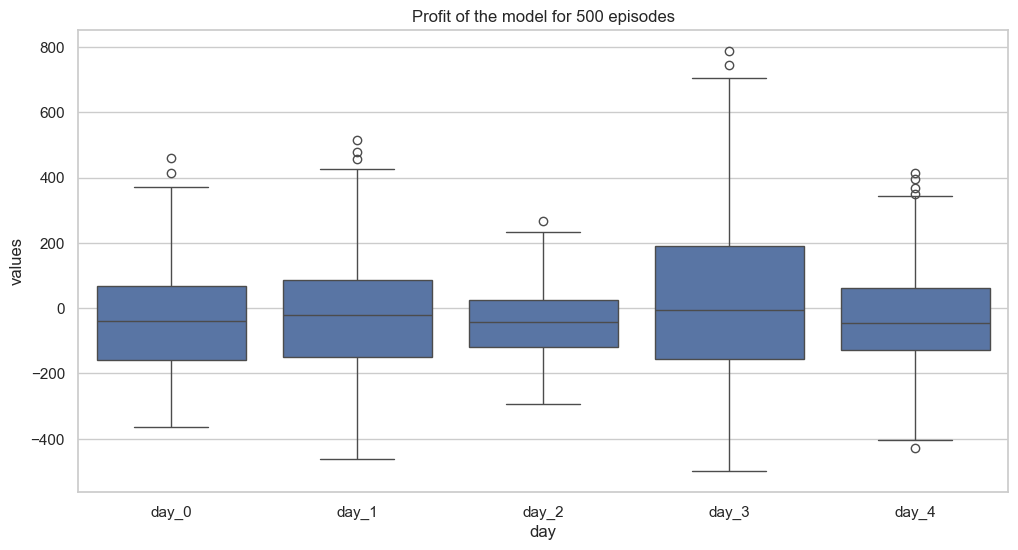

In [99]:

# plot the timesteps_test_df results with the index on the x axis and the values for the columns as the y axis and the column names as the color of the dots
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6)) 
sns.boxplot(x='day', y='values', data=timesteps_test_df_long)
plt.title(f'Profit of the model for {num_episodes} episodes')
plt.show()


In [11]:
data_path = 'C:/Users/WilliamFetzner/Documents/Trading/gym_mtsim_forked/gym_mtsim/data/symbols_forex_1hr_1_1_24_4_25_24 copy.pkl'
new_data_path = data_path.replace('copy', 'validation')

In [14]:
# with open(data_path, 'rb') as f:
#     symbols = pickle.load(f)
# current_data = symbols[1]['EURUSD']
# current_data.index = pd.to_datetime(current_data.index)
# current_data_validation_index = current_data[env_validation_2.time_points[0]:env_validation_2.time_points[-1]]
# symbols[1]['EURUSD'] = current_data_validation_index
# new_data_path = data_path.replace('copy', 'validation')
# with open(new_data_path , 'wb') as f:
#     pickle.dump(symbols, f)